In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.io import loadmat
from scipy.interpolate import interp1d
from functools import reduce
from tqdm.notebook import tqdm
import seaborn as sns
import time
import sobol
import itertools
import os
from pathlib import Path
import pickle

In [3]:
rawmat = loadmat('Gr-LFP_5000paths.mat')

In [4]:
# make all numbers on order 1 - better for neural netwroks
pathinfo = pd.DataFrame(rawmat['pathinfo'],columns = ['LLI','LAMPE','LAMNE','Capacity_Loss'])/100

In [5]:
values = list(rawmat['Cell_info'][0][:5])
keys = ['Positive electrode','Negative electrode','Loading Ratio','Offset','Resistance adjustment']
cellinfo = dict(zip(keys, values))
Qnorm = rawmat['Qnorm'].T.reshape(len(rawmat['Qnorm'].T))

Try two different types of training data: 
1. 1000 samples on a grid
2. 1000 samples from a sobol sequence

In [15]:
# find the closest sample in the available simulations
# probably a faster way to do this - investiage
def closest_sim(target,all_sims):
    all_sims['MSE_target'] = np.sum((target - all_sims.iloc[:,:3].values)**2,axis=1)
    return all_sims.loc[all_sims['MSE_target'] == all_sims['MSE_target'].min()].index.values[0]


In [21]:
# make sobol and grid samples

sobol_samples = sobol.sample(dimension=3, n_points=1000)

spacing = 0.1
grid_samples = list(itertools.product(list(np.arange(0,1,spacing)),list(np.arange(0,1,spacing)),list(np.arange(0,1,spacing))))


sparse_sobol_indeces,sparse_grid_indeces = [],[]
for i in tqdm(range(1000)):
    sparse_sobol_indeces.append(closest_sim(sobol_samples[i],pathinfo))
    sparse_grid_indeces.append(closest_sim(grid_samples[i],pathinfo))



  0%|          | 0/1000 [00:00<?, ?it/s]

In [142]:
ytrain_sets =  {'sobol':pathinfo.loc[pathinfo.index.isin(sparse_sobol_indeces)].sample(frac=1),
           'grid':pathinfo.loc[pathinfo.index.isin(sparse_grid_indeces)].sample(frac=1)}

Ntest = 10000

available_test_data_sobol = pathinfo.loc[~pathinfo.index.isin(sparse_sobol_indeces)]
test_data_sobol = available_test_data_sobol.loc[available_test_data_sobol.index.isin(np.random.choice(available_test_data_sobol.index,Ntest,replace=False))]
available_test_data_grid = pathinfo.loc[~pathinfo.index.isin(sparse_grid_indeces)]
test_data_grid = available_test_data_grid.loc[available_test_data_grid.index.isin(np.random.choice(available_test_data_grid.index,Ntest,replace=False))]

ytest_sets =  {'sobol':test_data_sobol,
          'grid':test_data_grid}

Discretize each voltage profile and transform it to a Q(V,LAMPE,LAMNE,LLI) - Q(V,0,0,0)

In [6]:
Vrange = np.array([2.25,4.05])
V_discrete = np.arange(Vrange[0],Vrange[1],1/1000)

f = interp1d(rawmat['volt'].T[0],Qnorm,bounds_error=False,fill_value="extrapolate")
Q0 = f(V_discrete)


discretized_profiles = np.zeros((len(pathinfo),len(V_discrete)))

for i in tqdm(range(len(rawmat['volt'].T))):
    v_temp = rawmat['volt'].T[i]
    f = interp1d(v_temp[~np.isnan(v_temp)],Qnorm[~np.isnan(v_temp)],bounds_error=False,fill_value="extrapolate")
    discretized_profiles[i,:] = f(V_discrete) - Q0

  0%|          | 0/515101 [00:00<?, ?it/s]

Understand the effects of preprocessing - different scalers

In [7]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [144]:
Xtrain_sets = {'unscaled':{},'minmax_scaled':{},'standard_scaled':{}}
Xtest_sets = {'unscaled':{},'minmax_scaled':{},'standard_scaled':{}}

for trainset_type in ['sobol','grid']:
    Xtrain_sets['unscaled'][trainset_type] = discretized_profiles[ytrain_sets[trainset_type].index]
    Xtest_sets['unscaled'][trainset_type]  = discretized_profiles[ytest_sets[trainset_type].index]
    

In [145]:
minmax_scaler = MinMaxScaler().fit(Xtrain_sets['unscaled']['grid'])
standard_scaler = StandardScaler().fit(Xtrain_sets['unscaled']['grid'])

for scaler,scalename in zip([minmax_scaler,standard_scaler],['minmax_scaled','standard_scaled']):
    for trainset_type in ['sobol','grid']:
        Xtrain_sets[scalename][trainset_type] = scaler.transform(Xtrain_sets['unscaled'][trainset_type])
        Xtest_sets[scalename][trainset_type]  = scaler.transform(Xtest_sets['unscaled'][trainset_type])

In [19]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from keras import backend as K
from keras import regularizers

In [33]:
def make_DNN():
    model = Sequential()
    model.add(Dense(256, input_dim=len(V_discrete), activation='relu',kernel_regularizer=regularizers.l2(0.0)))
    model.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0)))
    model.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.0)))
    model.add(Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.00)))
    model.add(Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.00)))
    model.add(Dense(8, activation='relu',kernel_regularizer=regularizers.l2(0.00)))
    model.add(Dense(3, activation='sigmoid'))
    
    model.compile(loss='mse', optimizer='adam', metrics=['mse','mae','accuracy'])
    
    return model

def make_DNN_dropout():
    model = Sequential()
    model.add(Dense(256, input_dim=len(V_discrete), activation='relu',kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.6))
    model.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.6))
    model.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(8, activation='relu',kernel_regularizer=regularizers.l2(0.00)))
    model.add(Dense(3, activation='sigmoid'))
    
    model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
    
    return model

In [10]:
from sklearn.metrics import mean_squared_error

In [11]:
def calc_accuracy(model,X_train,y_train,X_test,y_test,plot=True,axs=None, train_kwargs={},val_kwargs={}):

    if (plot) and (len(axs)<3):
        print(len(axs),len(metrics)+1)
        raise ValueError('specify the axes properly')

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    results = {}

    for i,mode in enumerate(['LLI','LAMPE','LAMNE']):
        
        RMSE_train = np.sqrt(mean_squared_error(y_train[:,i],y_train_pred[:,i]))
        RMSE_test = np.sqrt(mean_squared_error(y_test[:,i],y_test_pred[:,i]))
        results[mode] = [RMSE_train,RMSE_test]
        if plot:
        
            ax = axs[i]

            ax.scatter(y_test[:,i],y_test_pred[:,i],**train_kwargs)
            ax.scatter(y_train[:,i],y_train_pred[:,i],**val_kwargs)

            ax.set_xlim(-0.05,0.9)
            ax.set_ylim(-0.05,0.9)
    #         ax.text(0.9*ax.get_xlim()[1],0,'train RMSE: '+'{:0.2f}'.format(RMSE_train),color='blue',ha='right',va='bottom')
    #         ax.text(0.9*ax.get_xlim()[1],0.1*ax.get_ylim()[1],'test RMSE: '+'{:0.2f}'.format(RMSE_test),color='red',ha='right',va='bottom')


            ax.set_xlabel('True '+mode)
            ax.set_ylabel('Predicted '+mode)

            axins = inset_axes(ax, width="40%", height=1., loc=2)#,borderpad=3)

            axins.hist(y_train[:,i]-y_train_pred[:,i],density=True,alpha=0.5,color=train_kwargs['color'])
            axins.hist(y_test[:,i]-y_test_pred[:,i],density=True,alpha=0.5,color=val_kwargs['color'])
            axins.axes.yaxis.set_visible(False)
    
    results = pd.DataFrame(results,index=['train','test'])
    if plot:
        return results,axs
    else:
        return results

In [148]:
for scalename in ['unscaled','minmax_scaled','standard_scaled']:
    for trainset_type in ['sobol','grid']:
        
        print('training DNN on '+scalename+' '+trainset_type+' training set')
        
        X_train,y_train = Xtrain_sets[scalename][trainset_type],ytrain_sets[trainset_type].iloc[:,:3].values
        
        
        model = make_DNN()
        
        start_time = time.time()
        K.set_value(model.optimizer.learning_rate, 0.001)
        
        NN_result = model.fit(X_train, y_train, epochs=200, batch_size=64,verbose=0, validation_split=0.2,)

        end_time = time.time()
        print('Training the neural network took %0.0f seconds' % (end_time-start_time))
        
        # save model weights, history
        results_path = Path.cwd() / 'DNN_results' / trainset_type / scalename
        if not os.path.exists(results_path):
            os.makedirs(results_path)
        
        model.save(results_path / "fitDNN.h5")
        f = open(results_path / "DNN_history.pkl","wb")
        pickle.dump(NN_result.history,f)
        f.close()
        
        # calculate train and test errors
        X_test,y_test = Xtest_sets[scalename][trainset_type],ytest_sets[trainset_type].iloc[:,:3].values
        
        start_time = time.time()
        results = calc_accuracy(model,X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test,plot=False)

        end_time = time.time()
        print('Evaluating the neural network on test set took %0.0f seconds' % (end_time-start_time))
        
        results.to_csv(results_path / "RMSE_results.csv",sep=',')
        

training DNN on unscaled sobol training set
Training the neural network took 19 seconds
Evaluating the neural network on test set took 2 seconds
training DNN on unscaled grid training set
Training the neural network took 19 seconds
Evaluating the neural network on test set took 5 seconds
training DNN on minmax_scaled sobol training set
Training the neural network took 19 seconds
Evaluating the neural network on test set took 4 seconds
training DNN on minmax_scaled grid training set
Training the neural network took 20 seconds
Evaluating the neural network on test set took 5 seconds
training DNN on standard_scaled sobol training set
Training the neural network took 19 seconds
Evaluating the neural network on test set took 4 seconds
training DNN on standard_scaled grid training set
Training the neural network took 19 seconds
Evaluating the neural network on test set took 5 seconds


In [12]:
def plot_learning_curves(history,axs=None,metrics=['accuracy'], train_kwargs={},val_kwargs={}):
    if (axs is None) or (len(axs)<len(metrics)+1):
        print(len(axs),len(metrics)+1)
        raise ValueError('specify the axes properly')
        
    axs[0].plot(np.sqrt(history['loss']),**train_kwargs)
    axs[0].plot(np.sqrt(history['val_loss']),**val_kwargs)
    axs[0].set_title('model rmse loss')
    axs[0].set_ylabel('RMSE')
    axs[0].set_xlabel('epoch')

        
    for metric,ax in zip(metrics,axs[1:]):
        ax.plot(history[metric],**train_kwargs)
        ax.plot(history['val_'+metric],**val_kwargs)
        
        ax.set_title('model '+metric) 
        ax.set_ylabel(metric)
        ax.set_xlabel('epoch')

    return axs

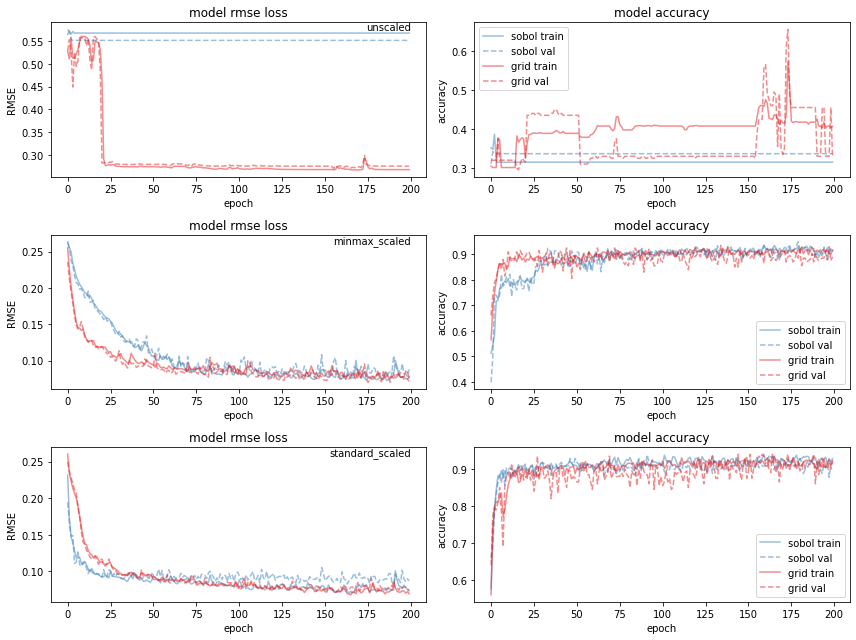

In [149]:
fig,ax_all = plt.subplots(3,2,figsize=(12,9))

for j,scalename in enumerate(['unscaled','minmax_scaled','standard_scaled']):
    axs = ax_all[j,:]
    for trainset_type,color in zip(['sobol','grid'],['#377eb8','#e41a1c']):
        results_path = Path.cwd() / 'DNN_results' / trainset_type / scalename
        infile = open(results_path / "DNN_history.pkl",'rb')
        history = pickle.load(infile)
        infile.close()
        
        axs = plot_learning_curves(history,axs,
                                   train_kwargs={'ls':'-','alpha':0.5,'label':trainset_type+' train','c':color},
                                   val_kwargs={'ls':'--','alpha':0.5,'label':trainset_type+' val','c':color})
        
        
        if trainset_type=='grid':
            axs[1].legend()
            axs[0].text(200,axs[0].get_ylim()[1],scalename,ha='right',va='top')
        
fig.tight_layout()
fig.savefig('figures/DNN_learning_curves.png',dpi=200,transparent=True)

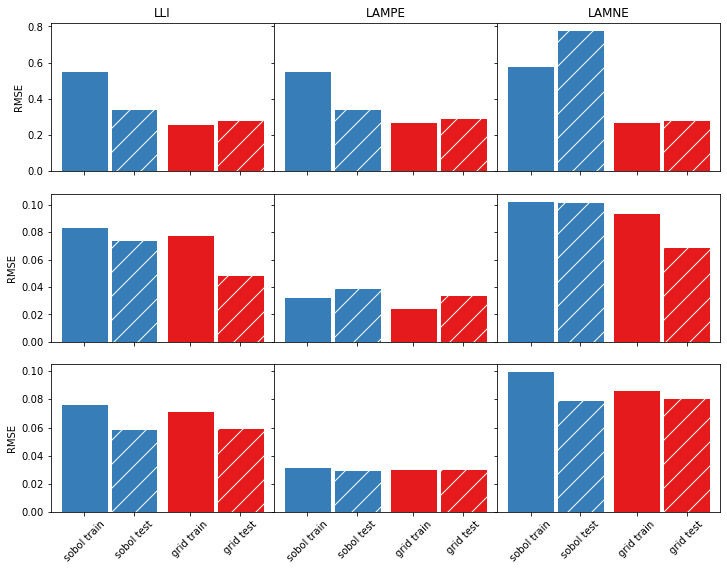

In [155]:
fig,ax_all = plt.subplots(3,3,figsize=(12,9),sharey='row',sharex=True)


for j,scalename in enumerate(['unscaled','minmax_scaled','standard_scaled']):
    axs = ax_all[j,:]
    for k,(trainset_type,color) in enumerate(zip(['sobol','grid'],['#377eb8','#e41a1c'])):
        results_path = Path.cwd() / 'DNN_results' / trainset_type / scalename
        results = pd.read_csv(results_path / 'RMSE_results.csv',sep=',',index_col='Unnamed: 0')
        
        for i,ax in enumerate(axs):
            ax.bar(k*1.7,results.iloc[0,i],fc=color,width=0.75,ec='w')
            ax.bar(k*1.7 + 0.8,results.iloc[1,i],fc=color,hatch='/',width=0.75,ec='w')
#             ax.set_ylim(0,0.9)
            if j==0:
                ax.set_title(results.columns[i])
            
    axs[0].set_ylabel('RMSE')
    
for ax in axs:
    ax.set_xticks([0,0.8,1.7,1.7+0.8])
    ax.set_xticklabels(['sobol train','sobol test','grid train','grid test'],rotation=45)
    
fig.subplots_adjust(wspace=0, hspace=0.15)
fig.savefig('figures/DNN_rmse.png',dpi=200,transparent=True)

observations:
- looks like whether you choose sobol or grid sampling to train a DNN, you can achieve similar results. maybe slightly better with grid sampling. this is subject to training of the NN
- some preprocessing is required. unscaled is not good
- LAMPE is easier to identify. system is more sensitive?
- what is sufficient RMSE to use this? We can basically identify parameters to within 8%
- test error is lower than trianing error? Is this due to the rigid and well-defined nature of the dataset?

# how does more training data improve the predictions?

In [59]:
# Ntrains = [1000,3000,5000]
Ntrains = [100,200,500]

for Ntrain in Ntrains:
        

    print('Analysing training set of size '+str(Ntrain))
    sobol_samples = sobol.sample(dimension=3, n_points=Ntrain)

    start_time = time.time()
    sparse_sobol_indeces = []
    for i in tqdm(range(Ntrain)):
        sparse_sobol_indeces.append(closest_sim(sobol_samples[i],pathinfo))
    end_time = time.time()
    print('grabbing closest simulations took %0.0f seconds' % (end_time-start_time))


    ytrain_set =  pathinfo.loc[pathinfo.index.isin(sparse_sobol_indeces)].sample(frac=1)

    Ntest = 10000

    available_test_data_sobol = pathinfo.loc[~pathinfo.index.isin(sparse_sobol_indeces)]
    ytest_set = available_test_data_sobol.loc[available_test_data_sobol.index.isin(np.random.choice(available_test_data_sobol.index,Ntest,replace=False))]


    Xtrain_set = discretized_profiles[ytrain_set.index]
    Xtest_set  = discretized_profiles[ytest_set.index]

    start_time = time.time()
    X_train,y_train = Xtrain_set,ytrain_set.iloc[:,:3].values
    scaler = MinMaxScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    end_time = time.time()
    print('rescaling data took %0.0f seconds' % (end_time-start_time))
    
    model = make_DNN() #_dropout()

    start_time = time.time()
    K.set_value(model.optimizer.learning_rate, 0.001)

    NN_result = model.fit(X_train, y_train, epochs=200, batch_size=64,verbose=0, validation_split=0.3,)

    end_time = time.time()
    print('Training the neural network took %0.0f seconds' % (end_time-start_time))

    # save model weights, history
    ntrainpath = 'Ntrain_'+str(Ntrain)
    results_path = Path.cwd() / 'DNN_results' / 'sobol' / ntrainpath

    if not os.path.exists(results_path):
        os.makedirs(results_path)

    model.save(results_path / "fitDNN.h5")
    f = open(results_path / "DNN_history.pkl","wb")
    pickle.dump(NN_result.history,f)
    f.close()
        
    start_time = time.time()
    X_test,y_test = Xtest_set,ytest_set.iloc[:,:3].values
    X_test = scaler.transform(X_test)
    results = calc_accuracy(model,X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test,plot=False)

    end_time = time.time()
    print('Evaluating the neural network on test set took %0.0f seconds' % (end_time-start_time))

    results.to_csv(results_path / "RMSE_results.csv",sep=',')

Analysing training set of size 100


  0%|          | 0/100 [00:00<?, ?it/s]

grabbing closest simulations took 1 seconds
rescaling data took 0 seconds
Training the neural network took 9 seconds
Evaluating the neural network on test set took 2 seconds
Analysing training set of size 200


  0%|          | 0/200 [00:00<?, ?it/s]

grabbing closest simulations took 2 seconds
rescaling data took 0 seconds
Training the neural network took 10 seconds
Evaluating the neural network on test set took 2 seconds
Analysing training set of size 500


  0%|          | 0/500 [00:00<?, ?it/s]

grabbing closest simulations took 5 seconds
rescaling data took 0 seconds
Training the neural network took 13 seconds
Evaluating the neural network on test set took 4 seconds


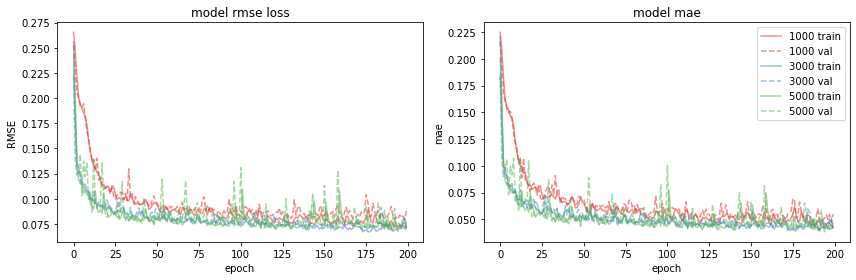

In [36]:
fig,axs = plt.subplots(1,2,figsize=(12,4))

for Ntrain,color in zip(Ntrains,['#e41a1c','#377eb8','#4daf4a']):
    ntrainpath = 'Ntrain_'+str(Ntrain)
    results_path = Path.cwd() / 'DNN_results' / 'sobol' / ntrainpath
    infile = open(results_path / "DNN_history.pkl",'rb')
    history = pickle.load(infile)
    infile.close()
    
    history['rmse'] = np.sqrt(history['mse'])
    history['val_rmse'] = np.sqrt(history['val_mse'])
        
    axs = plot_learning_curves(history,axs,metrics=['mae'],
                               train_kwargs={'ls':'-','alpha':0.5,'label':str(Ntrain)+' train','c':color},
                               val_kwargs={'ls':'--','alpha':0.5,'label':str(Ntrain)+' val','c':color})

        
axs[1].legend()
        
fig.tight_layout()
fig.savefig('figures/DNN_learning_curves_Ntrain.png',dpi=200,transparent=True)

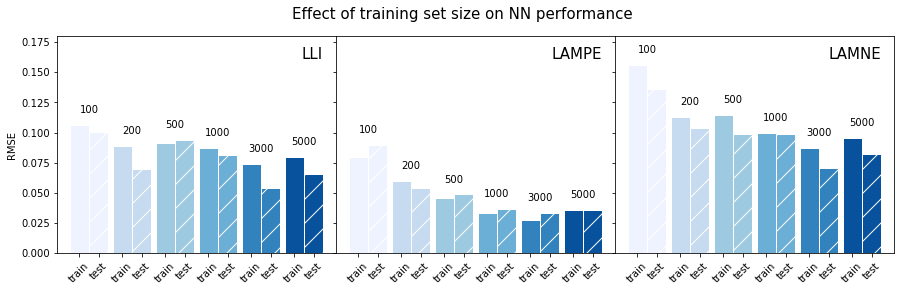

In [77]:
fig,axs = plt.subplots(1,3,figsize=(15,4),sharey='row',sharex=True)

Ntrains = [100,200,500,1000,3000,5000]
for k,(Ntrain,color) in enumerate(zip(Ntrains,['#eff3ff','#c6dbef','#9ecae1','#6baed6','#3182bd','#08519c'])):
    ntrainpath = 'Ntrain_'+str(Ntrain)
    results_path = Path.cwd() / 'DNN_results' / 'sobol' / ntrainpath
    results = pd.read_csv(results_path / 'RMSE_results.csv',sep=',',index_col='Unnamed: 0')
        
    for i,ax in enumerate(axs):
        ax.bar(k*2,results.iloc[0,i],fc=color,width=0.9,ec='w')
        ax.bar(k*2 + 0.9,results.iloc[1,i],fc=color,hatch='/',width=0.9,ec='w')
        
        ax.text(k*2+0.45,results.iloc[:,i].max()+0.01,str(Ntrain),ha='center')
        
            
axs[0].set_ylabel('RMSE')
axs[-1].set_ylim(0,axs[-1].get_ylim()[1]*1.1)
    
ticklocs = list(2*np.arange(len(Ntrains))) + list(2*np.arange(len(Ntrains))+0.9)
ticklocs.sort()
for ax,p in zip(axs,pathinfo.columns[:3]):
    ax.set_xticks(ticklocs)
    ax.set_xticklabels(['train','test']*len(Ntrains),rotation=45)
    ax.text(ax.get_xlim()[1]*0.95,ax.get_ylim()[1]*0.95,p,fontsize=15,va='top',ha='right')
    
fig.suptitle('Effect of training set size on NN performance',fontsize=15)    

fig.subplots_adjust(wspace=0, hspace=0.15)
fig.savefig('figures/DNN_rmse_Ntrain.png',dpi=200,transparent=True)

- We see the benefit of going to larger datasets
- There is some stochasticity here as well. since the test set is chosen at random, and the NN training is stochastic, probably I should repeat each one a couple times and report the statistics